# final


2025-05-14 17:35:56.261841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747244156.281495     783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747244156.288072     783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


I0000 00:00:1747244163.225457     783 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12203 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747244179.996744    1179 service.cc:148] XLA service 0x796d28003db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747244179.996824    1179 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747244181.220437    1179 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/675 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.0938 - loss: 3.3945   

I0000 00:00:1747244184.593699    1179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 ━━━━━━━━━━━━━━━━━━━━ 297s 416ms/step - accuracy: 0.6460 - loss: 1.1228 - val_accuracy: 0.9156 - val_loss: 0.2610
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 278s 408ms/step - accuracy: 0.8907 - loss: 0.3345 - val_accuracy: 0.9356 - val_loss: 0.1981
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 277s 406ms/step - accuracy: 0.9120 - loss: 0.2646 - val_accuracy: 0.9415 - val_loss: 0.1764
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 279s 411ms/step - accuracy: 0.9269 - loss: 0.2192 - val_accuracy: 0.9502 - val_loss: 0.1478
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 280s 412ms/step - accuracy: 0.9333 - loss: 0.1993 - val_accuracy: 0.9478 - val_loss: 0.1515
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 274s 402ms/step - accuracy: 0.9358 - loss: 0.1891 - val_accuracy: 0.9548 - val_loss: 0.1374
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 276s 405ms/step - accuracy: 0.9426 - loss: 0.1711 - val_accuracy: 0.9541 - val_loss: 0.1386
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 275s 404ms/step - accuracy: 0.9449 - loss: 0.16

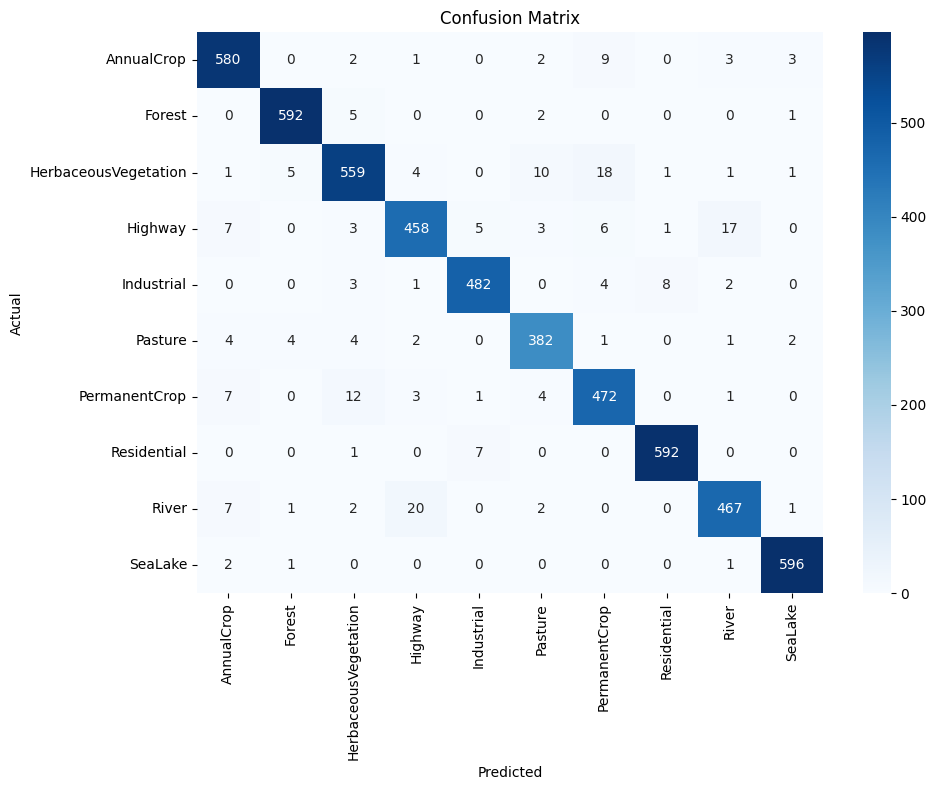

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


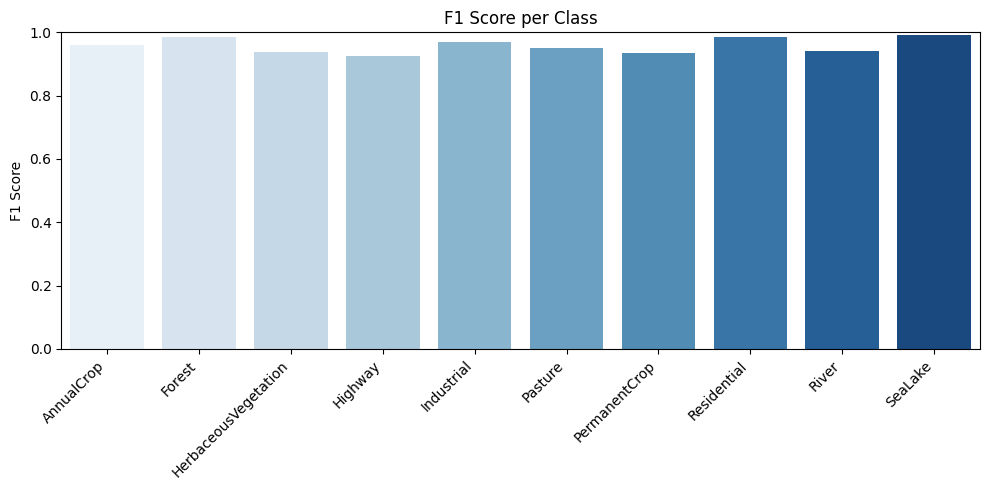

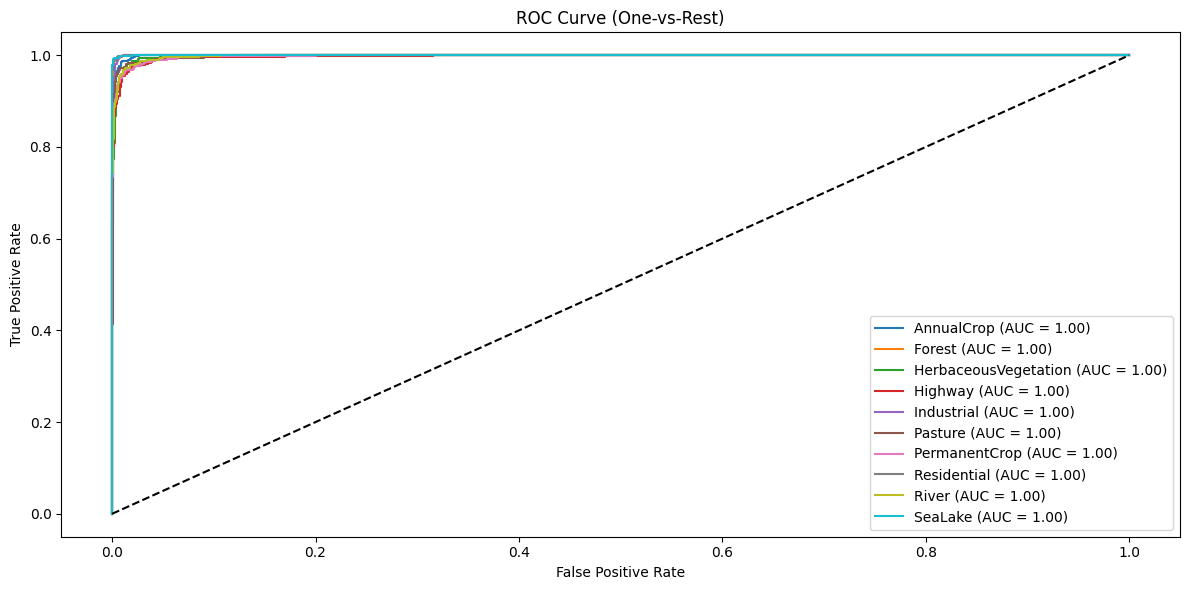

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Paths and Parameters
data_dir = '/kaggle/input/eurosat-2-land-type-classification/EuroSAT_RGB'
img_size = (224, 224)
batch_size = 32

# Data Loading with Augmentation
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15
)

train_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed
)

val_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=seed
)

num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Fine-tuning later

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Unfreeze for fine-tuning (optional)
# base_model.trainable = True
# model.compile(optimizer=optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, validation_data=val_generator, epochs=5)

# Evaluation
val_preds = model.predict(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(val_preds, axis=1)


# Print accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Validation Accuracy: {accuracy:.4f}")

# Visualization: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)

# F1 Score Plot
def plot_f1_scores(y_true, y_pred, classes):
    scores = f1_score(y_true, y_pred, average=None)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=scores, palette='Blues')
    plt.title('F1 Score per Class')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

plot_f1_scores(y_true, y_pred, class_names)

# ROC Curve
def plot_roc(y_true, y_score, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))
    plt.figure(figsize=(12, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_true_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(y_true, val_preds, class_names)


In [5]:
val_preds = model.predict(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(val_preds, axis=1)

accuracy = np.mean(y_pred == y_true)
print(f"Validation Accuracy: {accuracy:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step


In [7]:
accuracy = np.mean(y_pred == y_true)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9593


In [6]:
model.save('best_model.h5')
